# 1D Helmholtz Multilevel Development: Repetitive; Local Coarsening Derivation
* Constant $k$.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.

In [111]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [112]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "3-point"
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]

repetitive = True

# Number of test vectors.  
ideal_tv = True  # False    # Use eigenvectors or not.
num_examples = 3
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5176380902050416


## Level 0->1 Coarsening

In [113]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# TV and TV residual history.
x_log = []
r_log = []

### Relaxation

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.007e+00                    4.468e-01    2.250
INFO     1     5.308e-01 (0.528) [0.528]    3.322e-01    1.599 (0.710)
INFO     2     2.993e-01 (0.565) [0.546]    2.813e-01    1.068 (0.668)
INFO     3     1.857e-01 (0.621) [0.570]    2.560e-01    0.728 (0.683)
INFO     4     1.286e-01 (0.692) [0.599]    2.411e-01    0.535 (0.735)
INFO     5     9.867e-02 (0.767) [0.629]    2.309e-01    0.428 (0.801)
INFO     6     8.182e-02 (0.828) [0.659]    2.231e-01    0.367 (0.857)
INFO     7     7.106e-02 (0.868) [0.686]    2.168e-01    0.327 (0.893)
INFO     8     6.352e-02 (0.893) [0.709]    2.114e-01    0.300 (0.916)
INFO     9     5.788e-02 (0.911) [0.729]    2.067e-01    0.280 (0.931)
INFO     10    5.345e-02 (0.923) [0.746]    2.025e-01    0.264 (0.942)
INFO     11    4.989e-02 (0.933) [0.761]    1.987e-01    0.251 (0.951)
INFO     12    4.694e-02 (0.941) [0.775]    1.952e-01    0.240 (0.957)
INFO 

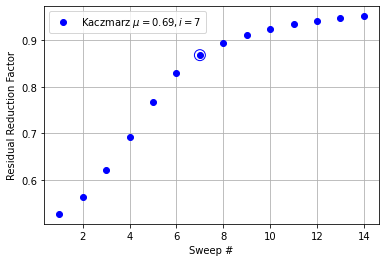

In [114]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95)
num_sweeps = method_info["Kaczmarz"][1]

In [115]:
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, num_sweeps))
    x = hm.setup.auto_setup.get_test_matrix(a, num_sweeps, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 3 ideal TVs


### Coarsening: Fixed (4/2)

In [116]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

Coarsening: a 4 nc 2 #windows 15 s [0.699 0.394 0.013 0.001]


,0,1,2,3,4,5,6,7,8,9
0,-0.48,-0.58,-0.54,-0.37,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.63,-0.20,0.29,0.69,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,-0.48,-0.58,-0.54,-0.37,0.00,0.00
3,0.00,0.00,0.00,0.00,-0.63,-0.20,0.29,0.69,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.48,-0.58


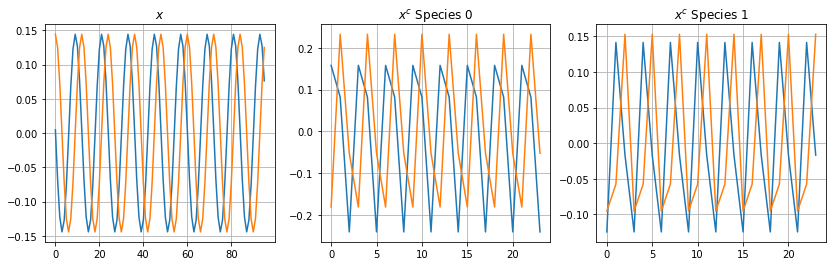

In [117]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [118]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=16 [0.435 0.245 0.14  0.136 0.106 0.075 0.063]


### Interpolation $P = R^T$

In [119]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()
print(p.todense())

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "Two-level")).transpose()
display(conv)

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

[[-0.475 -0.633]
 [-0.581 -0.197]
 [-0.545  0.286]
 [-0.375  0.692]]


,1,2,3,4,5,6,7
Mock,0.43,0.25,0.14,0.14,0.11,0.07,0.06
Two-level,0.46,0.30,0.40,0.36,0.34,0.34,0.33


INFO     L2 projection norm 1.00 A*A' projection norm 2.23


This intepolation is good up to $\nu = 2$, conv $\approx 0.5$.

### Interpolation by LS Fitting

In [120]:
calibers = (2, 3, 4)
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)
        interpolation_method = "ls"
        neighborhood = "extended"

        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber)

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))

        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, 
                    use_r_as_restriction=use_r_as_restriction), 
                nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append(two_level_conv)
        p_caliber.append(p)

    conv = pd.DataFrame(np.array([mock_conv] + l2c).transpose(), 
                        index=nu_values, columns=("Mock",) + tuple("Caliber {}".format(caliber)
                                                                  for caliber in calibers)).transpose()
    display(conv)

P^T*A*P
INFO     caliber 2 error l2 [0.02] a [4.58e+12]
INFO     caliber 3 error l2 [0.01] a [3.26e+12]
INFO     caliber 4 error l2 [0.00] a [6.21e-01]


,1,2,3,4,5,6,7
Mock,0.43,0.25,0.14,0.14,0.11,0.07,0.06
Caliber 2,0.45,0.30,0.38,0.37,0.32,0.33,0.32
Caliber 3,0.52,0.27,0.25,0.29,0.23,0.23,0.22
Caliber 4,0.53,0.27,0.17,0.14,0.14,0.09,0.05


R*A*P
INFO     caliber 2 error l2 [0.02] a [4.58e+12]
INFO     caliber 3 error l2 [0.01] a [3.26e+12]
INFO     caliber 4 error l2 [0.00] a [6.21e-01]


,1,2,3,4,5,6,7
Mock,0.43,0.25,0.14,0.14,0.11,0.07,0.06
Caliber 2,0.45,0.30,0.38,0.37,0.30,0.32,0.32
Caliber 3,0.50,0.27,0.29,0.31,0.28,0.25,0.26
Caliber 4,0.97,1.04,1.14,1.07,1.03,1.13,1.04


In [121]:
for caliber, p in zip(calibers, p_caliber):
#    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
#    display_html(styler._repr_html_(), raw=True)
    ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, None, use_r_as_restriction=use_r_as_restriction)
    ac = ml[1].a
    print("caliber {} nnz(P) {} fill-in {:.2f}".format(caliber, p.nnz, (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])))
    print("Max abs |Ac - Ac^T| {:.3e}".format(np.max(np.abs(ac - ac.transpose()))))
    display_df_side_by_side(pd.DataFrame(p[:6, :6].todense()),
                            pd.DataFrame(ac.todense()[:10,:10]), 
                        captions=("P", "A^1"))

caliber 2 nnz(P) 192 fill-in 2.00
Max abs |Ac - Ac^T| 3.509e-03


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.47 
 -0.63 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.58 
 -0.20 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.54 
 0.28 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.37 
 0.70 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 -0.47 
 -0.63 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 -0.58 
 -0.20 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.14 
 -0.08 
 0.18 
 0.24 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.08 
 -1.20 
 -0.33 
 -0.44 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.18 
 -0.33 
 -0.14 
 -0.08 
 0.18 
 0.24 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.24 
 -0.44 
 -0.08 
 -1.20 
 -0.33 
 -0.44 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.18 
 -0.33 
 -0.14 
 -0.08 
 0.18 
 0.24 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.24 
 -0.44 
 -0.08 
 -1.20 
 -0.33 
 -0.44 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.18 
 -0.33 
 -0.14 
 -0.08 
 0.18 
 0.24 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 0.24 
 -0.44 
 -0.08 
 -1.20 
 -0.33 
 -0.44 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.18 
 -0.33 
 -0.14 
 -0.08 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.24 
 -0.44 
 -0.08 
 -1.20

caliber 3 nnz(P) 288 fill-in 2.00
Max abs |Ac - Ac^T| 3.283e-03


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.49 
 -0.56 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.57 
 -0.26 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.52 
 0.35 
 0.04 
 0.00 
 0.00 
 0.00 
 
 
 3 
 -0.40 
 0.62 
 -0.05 
 0.00 
 0.00 
 0.00 
 
 
 4 
 -0.05 
 0.00 
 -0.49 
 -0.56 
 0.00 
 0.00 
 
 
 5 
 0.04 
 0.00 
 -0.57 
 -0.26 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.10 
 -0.07 
 0.18 
 0.21 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.07 
 -1.06 
 -0.29 
 -0.39 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.18 
 -0.29 
 -0.10 
 -0.07 
 0.18 
 0.21 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.21 
 -0.39 
 -0.07 
 -1.06 
 -0.29 
 -0.39 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.18 
 -0.29 
 -0.10 
 -0.07 
 0.18 
 0.21 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.21 
 -0.39 
 -0.07 
 -1.06 
 -0.29 
 -0.39 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.18 
 -0.29 
 -0.10 
 -0.07 
 0.18 
 0.21 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 0.21 
 -0.39 
 -0.07 
 -1.06 
 -0.29 
 -0.39 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.18 
 -0.29 
 -0.10 
 -0.07 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.21 
 -0.39 
 -0.07 
 -1.06

caliber 4 nnz(P) 384 fill-in 2.00
Max abs |Ac - Ac^T| 1.348e-03


P 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 
 
 
 
 0 
 -0.41 
 -0.40 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.62 
 -0.36 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 -0.56 
 0.45 
 0.09 
 0.11 
 0.00 
 0.00 
 
 
 3 
 -0.34 
 0.46 
 -0.12 
 -0.16 
 0.00 
 0.00 
 
 
 4 
 -0.09 
 0.18 
 -0.41 
 -0.40 
 0.00 
 0.00 
 
 
 5 
 0.07 
 -0.12 
 -0.62 
 -0.36 
 0.00 
 0.00 
 
 
 

 
 A^1 
 
 
   
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 
 
 
 
 0 
 -0.03 
 -0.04 
 0.14 
 0.13 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 1 
 -0.04 
 -0.55 
 -0.17 
 -0.13 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 2 
 0.14 
 -0.17 
 -0.03 
 -0.04 
 0.14 
 0.13 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 3 
 0.13 
 -0.13 
 -0.04 
 -0.55 
 -0.17 
 -0.13 
 0.00 
 0.00 
 0.00 
 0.00 
 
 
 4 
 0.00 
 0.00 
 0.14 
 -0.17 
 -0.03 
 -0.04 
 0.14 
 0.13 
 0.00 
 0.00 
 
 
 5 
 0.00 
 0.00 
 0.13 
 -0.13 
 -0.04 
 -0.55 
 -0.17 
 -0.13 
 0.00 
 0.00 
 
 
 6 
 0.00 
 0.00 
 0.00 
 0.00 
 0.14 
 -0.17 
 -0.03 
 -0.04 
 0.14 
 0.13 
 
 
 7 
 0.00 
 0.00 
 0.00 
 0.00 
 0.13 
 -0.13 
 -0.04 
 -0.55 
 -0.17 
 -0.13 
 
 
 8 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.14 
 -0.17 
 -0.03 
 -0.04 
 
 
 9 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.00 
 0.13 
 -0.13 
 -0.04 
 -0.55

$R A P$ is nearly symmetric, and is sparser than $P^T A P$, while giving almost the same 2-level convergence factors for $\nu \geq 2$.

### Solving $Ax = b$ - Convergence History

INFO         0 |r| 1.429e+01 RER 2.53098
INFO         1 |r| 1.629e+00 (0.11400) RER 0.23048 (0.09106) 7.070
INFO         2 |r| 2.051e-01 (0.12587) RER 0.02822 (0.12243) 7.268
INFO         3 |r| 2.754e-02 (0.13431) RER 0.00351 (0.12451) 7.840
INFO         4 |r| 3.558e-03 (0.12918) RER 0.00038 (0.10819) 9.361
INFO         5 |r| 4.619e-04 (0.12982) RER 0.00005 (0.12027) 10.104
INFO         6 |r| 6.141e-05 (0.13296) RER 0.00001 (0.19426) 6.916
INFO         7 |r| 8.301e-06 (0.13516) RER 0.00000 (0.14539) 6.430
INFO         8 |r| 1.130e-06 (0.13609) RER 0.00000 (0.14707) 5.949
INFO         9 |r| 1.551e-07 (0.13731) RER 0.00000 (0.12497) 6.537
INFO        10 |r| 2.096e-08 (0.13516) RER 0.00000 (0.13602) 6.495
INFO        11 |r| 2.917e-09 (0.13912) RER 0.00000 (0.14429) 6.263
INFO        12 |r| 3.955e-10 (0.13560) RER 0.00000 (0.13791) 6.158
INFO        13 |r| 5.517e-11 (0.13950) RER 0.00000 (0.14208) 6.046


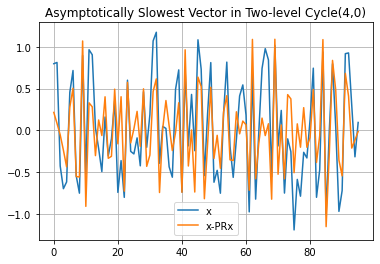

In [122]:
nu = 4
p = p_caliber[-1]
multilevel = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, aggregate_size)
y, _ = hm.repetitive.locality.two_level_conv_factor(multilevel, nu, print_frequency=1,
                                                   debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

### Operator Spectra

In [123]:
# Calculate eigenpairs at all levels.
vl = []
laml = []
for l, level in enumerate(multilevel):
    a = level.a
    lam, v = eig(a.todense())
    lam = np.real(lam)
    ind = np.argsort(np.abs(lam))
    lam = lam[ind]
    v = v[:, ind]
    vl.append(v)
    laml.append(lam)
    print(l, "lam", lam[:12])
    
# Interpolate eigenvectors at all levels to the finest level.
num_levels = len(multilevel)
vl_finest = []
for l in range(num_levels):
    v = vl[l]
    for k in range(l, 0, -1):
        v = multilevel[k].p.dot(v)
    vl_finest.append(v)

0 lam [-0.    -0.     0.062  0.062 -0.069 -0.069  0.116  0.116 -0.145 -0.145  0.162  0.162]
1 lam [ 0.    -0.     0.062  0.062 -0.069 -0.069  0.116  0.116 -0.144 -0.144  0.162  0.162]
